# Collaborative Filtering

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

sns.set()

## Loading Data

In [2]:
# loading data
df = pd.read_csv("./data/filtered_data.csv")
df.head()

,user_id,song_id,freq,artist,title
0,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOMWTWK12AB01860CD,2,Vampire Weekend,White Sky
1,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOBKRVG12A8C133269,1,Vampire Weekend,I Stand Corrected (Album)
2,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOXFXDH12A8C13326E,1,Vampire Weekend,The Kids Dont Stand A Chance (Album)
3,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOAYETG12A67ADA751,1,MIKA,Grace Kelly
4,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOUFNSM12A58A77715,1,Vampire Weekend,Walcott (Album)


## Processing Data

In [3]:
# let's see the number of unique users and songs now
print(f"Number of unique users: {df['user_id'].nunique()}")
print(f"Number of unique songs: {df['song_id'].nunique()}")


Number of unique users: 11212
Number of unique songs: 2000


In [4]:
df.groupby("user_id")["song_id"].nunique().describe()

count    11212.000000
mean        13.482340
std          3.937627
min         10.000000
25%         11.000000
50%         12.000000
75%         15.000000
max         44.000000
Name: song_id, dtype: float64

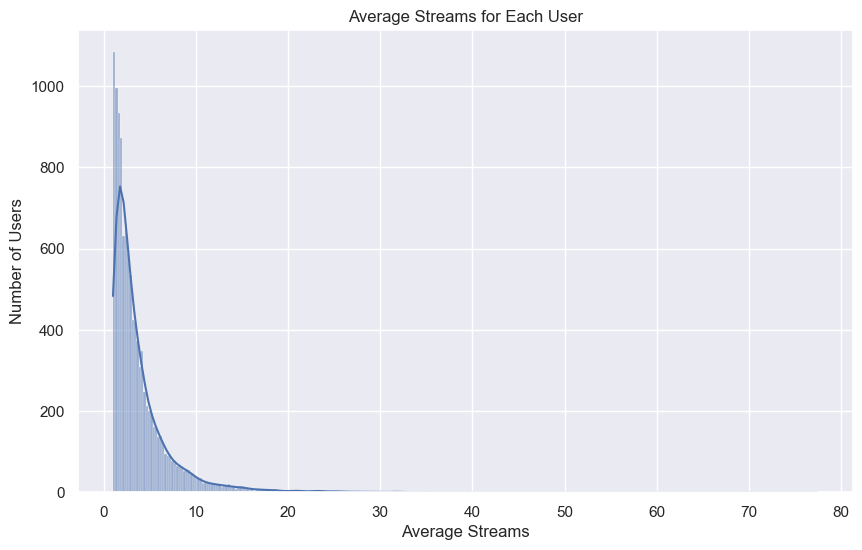

In [5]:
# there is a bias for each user, some users listen way more than others
# let's plot the average nb of listens for each user
user_means = df.groupby("user_id")["freq"].mean()
plt.figure(figsize=(10, 6))
sns.histplot(user_means, kde=True)
plt.title("Average Streams for Each User")
plt.xlabel("Average Streams")
plt.ylabel("Number of Users")
plt.show()


We can see the data is extremely right skewed. We will therefore work with deviations $$d(i,j)=s(i,j) - \hat{s_i}$$
where $s(i,j)$ is the number of listens for user $i$ and song $j$ and $\hat{s_i}$ is the mean number of listens for user $i$. That's essentially removing the user bias.


In [6]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2)

In [7]:
# Calculate user means from training data only
user_means = train_df.groupby("user_id")["freq"].mean()

# computing the deviations
train_df["freq_dev"] = train_df["freq"] - train_df["user_id"].map(user_means)

In [8]:
# Create mappings using full dataset to maintain consistent indices
user_ids = df["user_id"].unique()
song_ids = df["song_id"].unique()

user_id_map = {id_: i for i, id_ in enumerate(user_ids)}
song_id_map = {id_: i for i, id_ in enumerate(song_ids)}

user_id_map_inv = {v: k for k, v in user_id_map.items()}
song_id_map_inv = {v: k for k, v in song_id_map.items()}

In [9]:
# Create train sparse matrices
train_rows = [user_id_map[user_id] for user_id in train_df["user_id"]]
train_cols = [song_id_map[song_id] for song_id in train_df["song_id"]]
train_data_dev = train_df["freq_dev"].values

train_user_item_sparse_dev = csr_matrix(
    (train_data_dev, (train_rows, train_cols)), shape=(len(user_ids), len(song_ids))
)
train_user_item_sparse_dev[0].toarray()

array([[ 0.8, -0.2, -0.2, ...,  0. ,  0. ,  0. ]])

In [10]:
# we create an interaction mask to identify where actual interactions occurred (1s) vs missing data (0s)
train_data = train_df["freq"].values
train_interaction_mask = csr_matrix(
    (np.ones_like(train_data), (train_rows, train_cols)),
    shape=(len(user_ids), len(song_ids)),
)
train_interaction_mask[0].toarray()

array([[1, 1, 1, ..., 0, 0, 0]])

Here we also created a `interaction_mask` matrix. 

This way, we can:
- Use interaction_mask to identify where actual interactions occurred (1s) vs missing data (0s)
- Use user_item_sparse_dev for our normalized frequencies
- When needed, we can combine both matrices to distinguish between true zeros (check interaction_mask) and missing values



In [11]:
# Create test sparse matrices for evaluation - we don't really need the deviations here
test_rows = [user_id_map[user_id] for user_id in test_df["user_id"]]
test_cols = [song_id_map[song_id] for song_id in test_df["song_id"]]
test_data = test_df["freq"].values

test_user_item_sparse = csr_matrix(
    (test_data, (test_rows, test_cols)), shape=(len(user_ids), len(song_ids))
)

test_interaction_mask = csr_matrix(
    (np.ones_like(test_data), (test_rows, test_cols)),
    shape=(len(user_ids), len(song_ids)),
)

## Logic on a single user


In [13]:
# let's focus on the first user
user_id = 1
# minimum number of common items to consider a neighbor
min_common = 3
# number of neighbors to consider
K = 10


In [14]:
# Compute number of common items for user with all users
user_common_items = train_interaction_mask[user_id].dot(train_interaction_mask.T)
user_common_items

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3225 stored elements and shape (1, 11212)>

In [15]:
# this would be the top number of common items for the first user in the batch
user_common_items.toarray()[0][user_common_items.toarray()[0].argsort()[-10:][::-1]]


array([9, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [16]:
# extract the users with enough common items and remove the user
potential_neighbors = user_common_items.indices[user_common_items.data >= min_common]
potential_neighbors = potential_neighbors[potential_neighbors != user_id]
potential_neighbors


array([10331,  4383,  3742,  3106,  2109, 10197,  9848,  9468,  9238,
        7733,  7414,  6495,  6250,  3686,  3585,  3573,  3228,  2907,
        2744,  2375,  2316,  1925,  1207,   894,   523,   378,   208,
       10369, 11198, 11081, 10909, 10801, 10550, 10449, 10436, 10267,
       10216,  9565,  8993,  8961,  8589,  8509,  8302,  8183,  8124,
        8105,  7997,  7752,  7388,  7286,  6909,  6791,  6690,  6658,
        6368,  6128,  5829,  4558,  4523,  3882,  3745,  3614,  2998,
        2888,  2712,  2613,  2606,  2328,  2223,  2211,  1605,  1187,
        1111,  1070,  1068,   883,   680,   244,   121], dtype=int32)

In [17]:
# Get user vector
user_vector = train_user_item_sparse_dev.getrow(user_id)
user_mask = train_interaction_mask.getrow(user_id)

In [18]:
# Dictionary to store similarities
user_sims = {}

# Compute similarities with potential neighbors
for other_id in potential_neighbors:
    other_vector = train_user_item_sparse_dev.getrow(other_id)
    other_mask = train_interaction_mask.getrow(other_id)

    # Get common items mask
    common_mask = user_mask.multiply(other_mask)
    common_indices = common_mask.indices

    # Get vectors for common items
    user_common = user_vector.multiply(common_mask)
    other_common = other_vector.multiply(common_mask)

    # Compute cosine similarity
    similarity = cosine_similarity(user_common, other_common)[0, 0]
    user_sims[other_id] = similarity


In [19]:
# Keep top k similarities
top_k_users = sorted(user_sims.items(), key=lambda x: x[1], reverse=True)[:K]
top_k_users


[(np.int32(883), np.float64(0.9765241591476882)),
 (np.int32(10331), np.float64(0.9045340337332909)),
 (np.int32(2888), np.float64(0.9045340337332909)),
 (np.int32(7733), np.float64(0.9045340337332908)),
 (np.int32(3573), np.float64(0.9045340337332908)),
 (np.int32(378), np.float64(0.9045340337332908)),
 (np.int32(6909), np.float64(0.9045340337332908)),
 (np.int32(6690), np.float64(0.9045340337332908)),
 (np.int32(6658), np.float64(0.9045340337332908)),
 (np.int32(121), np.float64(0.859360783428583))]

## Main Function

In [20]:
def compute_user_similarities(interaction_mask, user_item_matrix, min_common=10, k=10):
    n_users = user_item_matrix.shape[0]
    similarities_dict = {}

    # we process each user 1 by 1
    for user_id in tqdm(range(n_users)):
        # Get users with enough common items
        user_common_items = interaction_mask[user_id].dot(interaction_mask.T)
        # Get indices where common items >= min_common
        potential_neighbors = user_common_items.indices[
            user_common_items.data >= min_common
        ]
        potential_neighbors = potential_neighbors[potential_neighbors != user_id]

        if len(potential_neighbors) == 0:
            similarities_dict[user_id] = {}
            continue

        # Get user vector
        user_vector = user_item_matrix.getrow(user_id)
        user_mask = interaction_mask.getrow(user_id)

        # dict to store similarities
        user_sims = {}

        # Compute similarities with neighbors
        for other_id in potential_neighbors:
            other_vector = user_item_matrix.getrow(other_id)
            other_mask = interaction_mask.getrow(other_id)

            # Get common items mask
            common_mask = user_mask.multiply(other_mask)

            # Get vectors for common items
            user_common = user_vector.multiply(common_mask)
            other_common = other_vector.multiply(common_mask)

            # Use cosine_similarity on sparse matrices directly
            similarity = cosine_similarity(user_common, other_common)[0, 0]

            if similarity > 0:
                user_sims[other_id] = similarity

        # Keep top k similarities
        if user_sims:
            top_k_users = sorted(user_sims.items(), key=lambda x: x[1], reverse=True)[
                :k
            ]
            similarities_dict[user_id] = dict(top_k_users)
        else:
            similarities_dict[user_id] = {}

    return similarities_dict

In [21]:
# compute the similarities
similarities_dict = compute_user_similarities(
    train_interaction_mask, train_user_item_sparse_dev, min_common=4
)


  0%|          | 0/11212 [00:00<?, ?it/s]

In [22]:
def predict_ratings(
    user_id, song_id, similarities_dict, user_item_matrix, interaction_mask
):
    """
    Predict rating for a user-song pair using similar users

    Parameters:
    -----------
    user_id: int
        Index of the user
    song_id: int
        Index of the song
    similarities_dict: dict
        Dictionary containing {user_id: {neighbor_id: similarity_score}}
    user_item_matrix: sparse matrix
        Matrix containing the normalized ratings
    interaction_mask: sparse matrix
        Matrix indicating which ratings exist
    """
    # Get similarity scores for this user
    user_similarities = similarities_dict.get(user_id, {})

    if not user_similarities:
        return None

    # Get column for this song from interaction mask
    song_mask = interaction_mask.getcol(song_id)
    # Get column for this song from ratings
    song_ratings = user_item_matrix.getcol(song_id)

    # Get similar users who rated this song
    similar_users_ratings = []
    similar_users_sims = []
    for similar_user, similarity in user_similarities.items():
        # Check if similar user has rated this song
        if song_mask[similar_user, 0]:
            rating = song_ratings[similar_user, 0]
            similar_users_ratings.append(rating)
            similar_users_sims.append(similarity)

    # If no similar users have rated this song return None
    if not similar_users_ratings:
        return None

    # computing the weighted average
    similar_users_ratings = np.array(similar_users_ratings)
    similar_users_sims = np.array(similar_users_sims)

    prediction = np.sum(similar_users_ratings * similar_users_sims) / np.sum(
        np.abs(similar_users_sims)
    )

    return prediction

## Test performance

In [23]:
# evaluating predictions on test
test_users, test_songs = test_interaction_mask.nonzero()

predictions = []
actuals = []

for user_id, song_id in tqdm(zip(test_users, test_songs), total=len(test_users)):
    pred_dev = predict_ratings(
        user_id,
        song_id,
        similarities_dict,
        train_user_item_sparse_dev,
        train_interaction_mask,
    )

    if pred_dev is not None:
        # Add back user mean
        real_user_id = user_id_map_inv[user_id]
        user_mean = user_means.loc[real_user_id]
        pred_rating = pred_dev + user_mean

        actual_rating = test_user_item_sparse[user_id, song_id]

        predictions.append(pred_rating)
        actuals.append(actual_rating)


print("first 3 predictions and actuals")
print(predictions[:3])
print(actuals[:3])


  0%|          | 0/30233 [00:00<?, ?it/s]

first 3 predictions and actuals
[np.float64(1.1184591125249828), np.float64(4.875), np.float64(1.81804114196637)]
[np.int64(1), np.int64(1), np.int64(5)]


In [24]:
# Calculate MAE
mae = np.mean(np.abs(np.array(predictions) - np.array(actuals)))
print(f"Test MAE: {mae:.3f}")

Test MAE: 3.968


## Some recommendations

I'm actually only using the training data to make recommendations here, but it's just for fun.


In [30]:
# get specific artist data
artist_df = df[df.artist == "Coldplay"]

# Get users who listen to that artist and their total song count
user_total_songs = df.groupby("user_id").freq.sum()
user_artist_songs = artist_df.groupby("user_id").freq.sum()

# Calculate ratio of Artist songs to total songs for each user
artist_ratio = pd.DataFrame(
    {"total_songs": user_total_songs, "artist_songs": user_artist_songs}
).fillna(0)
artist_ratio["ratio"] = artist_ratio["artist_songs"] / artist_ratio["total_songs"]
artist_ratio

,total_songs,artist_songs,ratio
user_id,,,
0003798d61a8010dbfd8010180b7107cbbb8a649,30,0.0,0.000000
00061a993bb3add5cc37b2ea28a9552337f2fe4d,40,0.0,0.000000
000a43eb37163bb2f93020e107a2d543f27257b7,14,0.0,0.000000
000ae9c80733348ff64cd3716a27477b94578d9d,11,0.0,0.000000
000dd7137b511a0c6e45880de551c6a7019ee4c3,60,0.0,0.000000
...,...,...,...
fff3b1ee05d9750e8868de9470ea46fcb0776f66,25,0.0,0.000000
fff4438f5d96c5ecd66678f2a22fd7bbed59625f,15,2.0,0.133333
fff5304527f3c658ce48cd7afa5b76b7b4172852,55,0.0,0.000000


In [31]:
# Find users with high artist ratio (e.g., >30%) and minimum number of artist songs (e.g., >3)
dedicated_fans = artist_ratio[
    (artist_ratio["ratio"] > 0.3) & (artist_ratio["artist_songs"] > 3)
].sort_values("ratio", ascending=False)

# Display top dedicated Eminem fans
print("Top Eminem fans (by ratio of Eminem songs to total songs):")
print(dedicated_fans.head())

# extract top user id
user_id = dedicated_fans.index[0]


Top Eminem fans (by ratio of Eminem songs to total songs):
                                          total_songs  artist_songs  ratio
user_id                                                                   
e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a           17          17.0    1.0
9d2f4eb96cd0df48e2eaf3ba0f07bbd3d1237d3e           21          21.0    1.0
89d6750983d96a6b22bd423e1ea80d633a397b18           11          11.0    1.0
617f1d5cdd8695ea1f3360da737e406b090cb26c           40          40.0    1.0
6d06c4543d053b659044331eee94fa3c04ad60bb           21          21.0    1.0


In [32]:
# get all songs for this user
user_songs = df[df["user_id"] == user_id]
user_songs.head()


,user_id,song_id,freq,artist,title
149064,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,SOSQQGF12A6310F0FB,1,Coldplay,Politik
149065,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,SOKLRPJ12A8C13C3FE,1,Coldplay,The Scientist
149066,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,SOOWPBJ12A8C137FB4,1,Coldplay,Lost!
149067,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,SOEWTBE12A58A7E7C2,1,Coldplay,Strawberry Swing
149068,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,SOQWSHS12A6701C576,1,Coldplay,X & Y


In [33]:
# get all songs that are not in the user's song list
all_songs = df["song_id"].unique()
non_user_songs = np.setdiff1d(all_songs, user_songs["song_id"].unique())
non_user_songs

# get the top K recommendations for this user
K = 3
top_recommendations = []

for song_id in non_user_songs:
    pred_dev = predict_ratings(
        user_id_map[user_id],
        song_id_map[song_id],
        similarities_dict,
        train_user_item_sparse_dev,
        train_interaction_mask,
    )

    if pred_dev is not None:
        top_recommendations.append((song_id, pred_dev))

# sort by prediction and get the top K
top_recommendations.sort(key=lambda x: x[1], reverse=True)
top_recommendations[:K]

# let's see the actual titles of the recommendations
for song_id, pred_dev in top_recommendations[:K]:
    # get the artist and song title
    song_artist = df[df["song_id"] == song_id]["artist"].values[0]
    song_title = df[df["song_id"] == song_id]["title"].values[0]
    print(f"{song_title} by {song_artist}")

    # print the prediction
    print(f"Predicted # streams: {pred_dev:.2f}")
    print()


Sayonara-Nostalgia by Base Ball Bear
Predicted # streams: 36.73

With Or Without You by U2
Predicted # streams: 25.35

Hold Me_ Thrill Me_ Kiss Me_ Kill Me by U2
Predicted # streams: 16.35

